<a href="https://colab.research.google.com/github/Rocks-n-Code/COGCCpy/blob/master/Salt_Cavern_Workflows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salt Cavern Workflows with Python

- Well spot creation with *geopandas*
- Well deviation survey with *wellpathpy*
- Sonar file processing with *SaltPy*
- 3D Visualization with *PyVista*

In [34]:
!pip install wellpathpy

!pip install pdfminer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 2.1 MB/s eta 0:00:00


In [35]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import Point, LineString
import folium
import folium.plugins as plugins
import wellpathpy as wp

import io
import requests
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage

pd.set_option('display.max_columns', None)

___

## Well Spot Shapefile
Let's make a GIS file for the location of well. In this case we will use PPG007B as an example.




*All data is publically avalible through [SONRIS](https://sonlite.dnr.state.la.us/ords/f?p=108:2).*

[PPG 007B Deviation Survey](https://sonlite.dnr.state.la.us/dnrservices/redirectUrl.jsp?dDocname=14325104&showInline=True)



POINT Z (2623600 643684 12.6)


<Axes: >

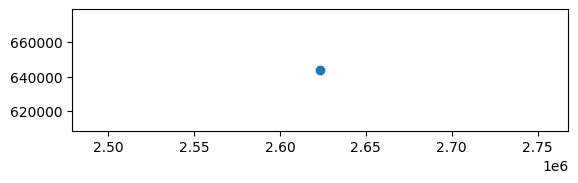

In [19]:
x,y,z = 2623600.00, 643684.00, 12.6

crs = 'EPSG:3452'
point = Point(x,y,z)
print(point)

wells = gpd.GeoDataFrame({'Well_No':['PPG-007B'],
                          'serial_no':[67270],
                          'geometry':[point]},
                         crs=crs)
wells.plot()

In [82]:
# Change Coordinate Referance System
wells_wgs84 = wells.to_crs('EPSG:4326')
point = wells_wgs84.at[0,'geometry']
x0,y0 = [p[0] for p in point.xy]
print(x0,y0)

## View with Folium
m = folium.Map(location=[y0,x0],
               tiles='Cartodb dark_matter',
               zoom_start=10)

# Add a marker
folium.Marker(
              [y0,x0],
              popup='PPG 007B',
              icon=plugins.BeautifyIcon(
                              icon="circle-small",
                              icon_shape="circle",
                              border_color='blue',
                              background_color='lightblue'
                          )
              ).add_to(m)

m

-93.41509792962904 30.25358561957733


In [32]:
## Save File
wells.to_file('ExampleWells.shp')
wells.to_file('ExampleWells_WSG84.gpkg')

___
# Well Deviation

For well deviation surveys that are not in ascii text I really like the snip tool in Windows 11 that has OCR. I've pasted the data below for you.

In [46]:
# Deviation Survey Raw Data
lines = '''0.0
100.0
200.1
300.0
400.0
500.0
600.0
700.0
800.0
900.
999.9
1100.0
1200.0
1300.0
1400.0
1500.0
1600.0
1700.0
1800.0
1899.9
2000.0
2100.0
2200.0
2300.0
2400.0
2501.0
0.0
267.3
265.3
268.3
253.3
264.3
255.3
354.3
343.3
330.3
282.3
277.3
275.3
284.3
294.3
345.3
345.3
354.3
25.3
34.3
27.3
42.3
50.3
42.3
48.3
104.3
0.0
0.3
0.2
0.2
0.3
0.4
0.2
0.4
0.8
0.7
1.9
1.6
1.5
1.1
1.0
0.9
0.8
0.6
0.4
0.5
0.4
0.5
0.4
0.3
0.2
0.8'''.split('\n')

# Number of lines
n = int(len(lines) / 3)

# Seperate Columns
md = lines[:n]
azi = lines[n:n*2]
inc = lines[n*2:]

# Make DataFrame
dev = pd.DataFrame({'md':md, 'azi': azi, 'inc':inc})
dev = dev.astype(float)

dev.head()

,md,azi,inc
0,0.0,0.0,0.0
1,100.0,267.3,0.3
2,200.1,265.3,0.2
3,300.0,268.3,0.2
4,400.0,253.3,0.3


In [49]:
## Make a wellpathpy object with the raw data
dev = wp.deviation(md = dev.md,
                   inc = dev.inc,
                   azi = dev.azi)

# LAS files are often on 0.5 ft steps so lets resample to 1/2' intervals.
depths = np.arange(0, dev.md.max()+1, 0.5)

pos = dev.minimum_curvature().resample(depths = depths)
dev2 = pos.deviation()

,md,azi,inc,tvd,n,e,x,y,z,dx,dy,dz,geometry
4998,2499.0,104.077702,0.785059,2498.774249,12.645099,-13.248558,2.623587e+06,643696.645099,-2486.174249,-13.248558,12.645099,-0.225751,POINT Z (2623586.751 643696.645 -2486.174)
4999,2499.5,104.104436,0.791104,2499.274202,12.643425,-13.241888,2.623587e+06,643696.643425,-2486.674202,-13.241888,12.643425,-0.225798,POINT Z (2623586.758 643696.643 -2486.674)
5000,2500.0,104.198402,0.791868,2499.774154,12.641736,-13.235190,2.623587e+06,643696.641736,-2487.174154,-13.235190,12.641736,-0.225846,POINT Z (2623586.765 643696.642 -2487.174)
5001,2500.5,104.223994,0.797914,2500.274106,12.640033,-13.228466,2.623587e+06,643696.640033,-2487.674106,-13.228466,12.640033,-0.225894,POINT Z (2623586.772 643696.64 -2487.674)
5002,2501.0,104.317045,0.798680,2500.774058,12.638316,-13.221715,2.623587e+06,643696.638316,-2488.174058,-13.221715,12.638316,-0.225942,POINT Z (2623586.778 643696.638 -2488.174)


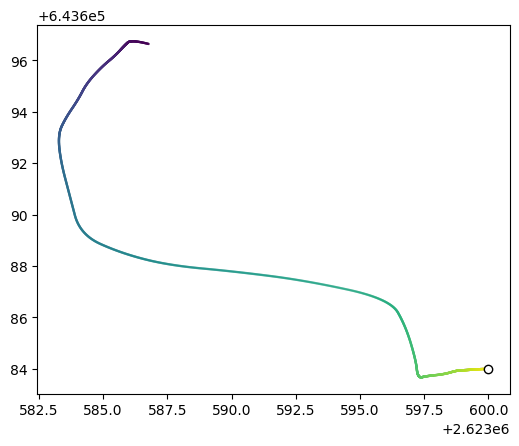

In [78]:
# Let's make a dataframe of that data
devsurv = pd.DataFrame({'md':dev2.md, 'azi':dev2.azi, 'inc':dev2.inc,
                        'tvd':pos.depth, 'n':pos.northing, 'e':pos.easting})

# Add x,y,z data of where we are refrenced in space.
# Note: Be careful if the survey is from KB then you'll need the APD
devsurv['x'] = x + devsurv['e']
devsurv['y'] = y + devsurv['n']
devsurv['z'] = z - devsurv['tvd']

# We want to know in 3D space how any MD has moved from straight down to
#  process our sonars. Let's add those columns
devsurv['dx'] = devsurv['e']
devsurv['dy'] = devsurv['n']
devsurv['dz'] = devsurv['tvd'] - devsurv['md']

# Geometry
devsurv['geometry'] = gpd.points_from_xy(devsurv.x, devsurv.y, devsurv.z)

# Change from pandas.DataFrame to geopandas.GeoDataFrame
devsurv = gpd.GeoDataFrame(devsurv, geometry='geometry', crs=wells.crs)

# Plot & Preview Points
ax = devsurv.plot(c=devsurv['z'], alpha=0.3, markersize=0.5)
wells.plot(color='white', edgecolor='k', ax=ax)

devsurv.tail()

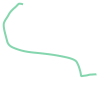

In [79]:
## Make Lines GIS File
line = LineString(devsurv.geometry)
line

<Axes: >

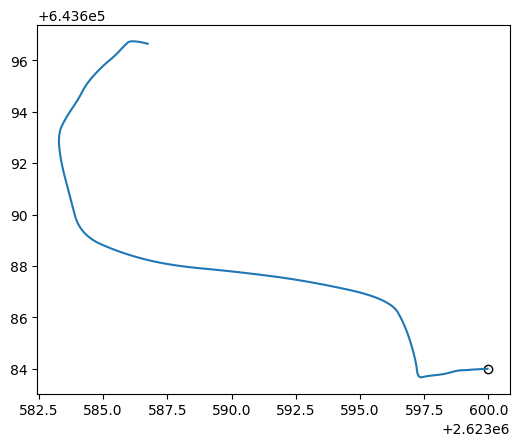

In [70]:
# Make Deviation Survey Line GIS
lines = wells.copy()
lines['geometry'] = line

# Plot and Preview Line
ax = lines.plot()
wells.plot(color='white', edgecolor='k', ax=ax)

In [80]:
## Save out files
devsurv.to_file('ExampleDevPnts.gpkg')
lines.to_file('ExampleDevLine.gpkg')

___

# Processing Sonar

Sonar come in several flavors unique to the vedors who ran the survey. Sonarwire, now part of Empire Wireline is one of the most common vendors in the United States. Their `cwr` file can be converted with their software *Sonar Post Processing* to export an ascii file known as a `lwt` (long wall table). The `lwt` format is optimized for printing and has a table per depth and inclination with the ranges arranged in a base azimuth row and addition azimuth column. This `lwt` is found, with small variations, is found with other vendors. We move these

Agapito has been internally develping python package `SonarPy` which is planned for public release in 2026. We will outline the workflow of processing with `SaltPy`.

---

#### Parsing a PDF with Python

We will start with an example that occurs all to often where we are not provided an original file from the vendor and we but convert a pdf into a usable format. [Public data source example: PPG 007B April 22, 2025](https://sonlite.dnr.state.la.us/dnrservices/redirectUrl.jsp?dDocname=15234027&showInline=True)

In [122]:
def pull_pdf_lwt_SONIC_SURVEYS(url, start=0, end=9999):
    '''
    Parses SONIC SURVEY digital pdfs (does not work on scanned pdfs) for the text
    of the lwt pages. Optional page numbers speed this up.

    INPUTS
    url: url of document, redirects may not work
    start (optional): int, starting page index of lwt (first page is 0)
    end (optional): int, end page index of lwt ("Page 100" would be index 99)
    '''
    # Step 1: Download the PDF from the GitHub raw link
    response = requests.get(url)
    response.raise_for_status()  # Raise error if download fails

    # Step 2: Convert to a file-like object
    fp = io.BytesIO(response.content)

    # PDFMiner setup
    rsrcmgr = PDFResourceManager()
    retstr = io.StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    interpreter = PDFPageInterpreter(rsrcmgr, device)

    # Extraction logic
    txtlst = []
    page_no = 0
    for pageNumber, page in enumerate(PDFPage.get_pages(fp)):
        if page_no < start:
            page_no += 1
            continue
        elif page_no > end:
            break
        elif pageNumber == page_no:
            interpreter.process_page(page)

            data = retstr.getvalue()
            t = data.encode('utf-8')
            if (b'DEPTH' in t) & (b'Bearing' in t) & (b'TILT' in t):
                txtlst.append(t)

            # Clear the StringIO buffer
            retstr.truncate(0)
            retstr.seek(0)

        page_no += 1

    return txtlst

rawurl = 'https://github.com/Rocks-n-Code/PythonCourse/blob/master/data/PPG7B_20250311_15234027~1.pdf?raw=true'
txtlst = pull_pdf_lwt_SONIC_SURVEYS(rawurl, start=61, end=128)

print('Pages',len(txtlst))
txtlst[0]

Pages 68


b'OFFICE OF CONSERVATION - INJECTION & MINING DIVISION - MAY 29 2025, Page 62 of 137\n\nDEPTH\nBearing\n0\n24\n48\n72\n96\n120\n144\n168\n192\n216\n240\n264\n288\n312\n336\n\nDEPTH\nBearing\n0\n24\n48\n72\n96\n120\n144\n168\n192\n216\n240\n264\n288\n312\n336\n\nDEPTH\nBearing\n0\n24\n48\n72\n96\n120\n144\n168\n192\n216\n240\n264\n288\n312\n336\n\n2515.1\n+ 0\n165.7\n166.3\n161.8\n157.1\n153.2\n160.9\n185.9\n206.9\n195.7\n82.2\n173.1\n171.0\n134.7\n168.6\n179.0\n\n2517.1\n+ 0\n168.7\n166.9\n162.4\n156.8\n153.4\n163.7\n186.5\n207.2\n196.5\n183.8\n174.2\n172.8\n170.1\n168.6\n179.6\n\n2519.2\n+ 0\n168.5\n167.9\n162.9\n156.5\n153.5\n166.0\n185.6\n208.7\n197.7\n189.7\n175.4\n172.8\n170.1\n168.6\n179.5\n\n+ 3\n153.8\n164.8\n161.2\n153.4\n154.1\n162.8\n186.2\n112.1\n197.1\n180.8\n103.8\n171.0\n162.9\n44.2\n80.7\n\n+ 3\n162.4\n166.6\n160.6\n154.7\n154.4\n169.2\n186.2\n204.3\n198.9\n182.9\n171.3\n172.8\n170.4\n167.5\n171.3\n\n+ 3\n164.2\n166.3\n161.5\n155.3\n155.1\n169.6\n187.3\n204.3\n199.2\n18

---

#### Parse Text with Python

PDF's often do not preserve data relationships of tables all that well. In this case we find that the "columns" run through the three tables on a page. This behavior is consistent so we can parse this with Python and make a transformed table that has one shot per row.

In [205]:
def parse_txtlst_to_dfT(txtlst):
    '''double new line delimination for lines, columns extend through tables'''
    dfT = pd.DataFrame()
    for tl in txtlst:
        tl = tl.decode('utf-8')

        # Clean off header
        tl = tl[tl.index('DEPTH'):]

        # number of tables on the page
        ntbls = tl.count('DEPTH')

        ## Data in this example are in columns of all the tables.
        # Split Accordingly.
        data = [p.split('\n') for p in tl.split('\n\n')]

        # pad columns
        colmax = max([len(p) for p in data])
        data = [[np.nan]+p if len(p) < colmax else p for p in data ]

        # drop last (short) one
        data = [x for x in data if len(x) == colmax]

        # Make array for easier parsing
        a = np.array(data)

        # Iterrate through the three tables
        for i in range(0, ntbls):
            #print(i)
            a0 = a[i::3]
            headline = a0[:,0]
            headline = [x for x in headline if x != 'nan']
            header = {str(k):str(v) for k,v in zip(headline[::2], headline[1::2])}

            rs = a0[1:,2:].astype(float).T.flatten()
            n = rs.shape[0]
            step = 360 / n
            azi = np.arange(0,360,step)

            # Make dataframe of each table
            temp = pd.DataFrame({'depth':[header['DEPTH']]*n,
                                'tilt':[header['TILT']]*n,
                                'vos':[header['VOS']]*n,
                                'cAzi':azi,
                                'r':rs})

            # Add table transformed to the end of dfT
            dfT = pd.concat([dfT,temp], ignore_index=True)

    dfT = dfT.astype(float)

    return dfT

dfT=parse_txtlst_to_dfT(txtlst)
dfT

,depth,tilt,vos,cAzi,r
0,2515.1,0.0,5936.2,0.0,165.7
1,2515.1,0.0,5936.2,3.0,153.8
2,2515.1,0.0,5936.2,6.0,163.0
3,2515.1,0.0,5936.2,9.0,150.6
4,2515.1,0.0,5936.2,12.0,161.8
...,...,...,...,...,...
24475,3094.0,0.0,5961.3,345.0,20.9
24476,3094.0,0.0,5961.3,348.0,21.3
24477,3094.0,0.0,5961.3,351.0,21.3
24478,3094.0,0.0,5961.3,354.0,21.3


---

# SaltPy

While we're close to release but not quite there. We'll move to Matt's presentation for this section.

,depth,tilt,vos,cAzi,r
1920,2613.9,89.0,5937.8,0.0,98.8
1921,2613.9,89.0,5937.8,3.0,99.0
1922,2613.9,89.0,5937.8,6.0,99.0
1923,2613.9,89.0,5937.8,9.0,99.0
1924,2613.9,89.0,5937.8,12.0,98.8
...,...,...,...,...,...
23995,3079.0,3.0,5961.3,345.0,44.4
23996,3079.0,3.0,5961.3,348.0,44.5
23997,3079.0,3.0,5961.3,351.0,43.9
23998,3079.0,3.0,5961.3,354.0,44.6


In [111]:
fp